In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import glob 
import os 
import pickle 
from scipy.spatial.transform import Rotation as R 
from scipy.spatial import KDTree 

In [14]:
# pose transformation functions 
# TODO: clean up and consolidate functions 

# convert pose to transformation matrix 
def pose2transform(pose):
    if pose.ndim == 1:
        if pose.shape[0] == 6: 
            T = np.eye(4) 
            T[:3, :3] = R.from_euler('xyz', pose[3:], degrees=True).as_matrix() 
            T[:3, 3] = pose[:3] 
            return T 
        elif pose.shape[0] == 7: 
            T = np.eye(4) 
            T[:3, :3] = R.from_quat(pose[3:], scalar_first=True).as_matrix() 
            T[:3, 3] = pose[:3] 
            return T 
    else: 
        if pose.shape[1] == 6: 
            T = np.zeros((pose.shape[0], 4, 4)) 
            for i in range(pose.shape[0]): 
                T[i, :3, :3] = R.from_euler('xyz', pose[i, 3:], degrees=True).as_matrix() 
                T[i, :3, 3] = pose[i, :3] 
            T[:, 3, 3] = 1 
            return T 
        elif pose.shape[1] == 7: 
            T = np.zeros((pose.shape[0], 4, 4)) 
            for i in range(pose.shape[0]): 
                T[i, :3, :3] = R.from_quat(pose[i, 3:], scalar_first=True).as_matrix() 
                T[i, :3, 3] = pose[i, :3] 
            T[:, 3, 3] = 1 
            return T 
        
def poses7D2poses6D(poses):
    if poses.ndim == 1: 
        poses6D = np.zeros(6) 
        poses6D[:3] = poses[:3] 
        poses6D[3:] = R.from_quat(poses[3:], scalar_first=True).as_euler('xyz', degrees=True) 
        return poses6D
    else:  
        poses6D = np.zeros((poses.shape[0], 6)) 
        for i in range(poses.shape[0]): 
            poses6D[i, :3] = poses[i, :3] 
            poses6D[i, 3:] = R.from_quat(poses[i, 3:], scalar_first=True).as_euler('xyz', degrees=True) 
        return poses6D 

# convert transformation matrix to pose 
def transform2pose(T):
    pose = np.zeros(7) 
    pose[:3] = T[:3, 3] 
    pose[3:] = R.from_matrix(T[:3, :3]).as_quat(scalar_first=True) 
    return pose 

def pose6D2transform(pose):
    T = np.eye(4) 
    T[:3, :3] = R.from_euler('xyz', pose[3:], degrees=True).as_matrix() 
    T[:3, 3] = pose[:3] 
    return T 

def transform2pose6D(T):   
    pose = np.zeros(6) 
    pose[:3] = T[:3, 3] 
    pose[3:] = R.from_matrix(T[:3, :3]).as_euler('xyz', degrees=True) 
    return pose 

# transform array of poses by a given pose 
def transform_poses(poses, delta_pose): 
    T_delta = pose2transform(delta_pose) 
    transformed_poses = np.zeros_like(poses) 
    for i in range(poses.shape[0]):
        transformed_poses[i] = transform2pose(np.linalg.inv(T_delta) @ pose2transform(poses[i])) # T_P0Pi = T_P0H @ T_HPi  
    return transformed_poses 

def transform_poses6D(poses, delta_pose): 
    T_delta = pose6D2transform(delta_pose) 
    transformed_poses = np.zeros_like(poses) 
    for i in range(poses.shape[0]):
        transformed_poses[i] = transform2pose6D(np.linalg.inv(T_delta) @ pose6D2transform(poses[i])) # T_P0Pi = T_P0H @ T_HPi  
    return transformed_poses 

def nearest_neighbor(P_t, P_s): 
    kdtree = KDTree(P_t) 
    dist, idx = kdtree.query(P_s) 
    correspondences = P_t[idx] 
    return correspondences 

def compute_delta_pose(P_s, P_t): 
    # crude estimate of transformation using mean, technically not the best way to do this since 6D pose is not smooth 
    if P_s.ndim == 1: 
        mean_pose_s = P_s 
    else: 
        mean_pose_s = np.mean(P_s, axis=0) 
    if P_t.ndim == 1: 
        mean_pose_t = P_t 
    else: 
        mean_pose_t = np.mean(P_t, axis=0) 
    T_s = pose6D2transform(mean_pose_s) 
    T_t = pose6D2transform(mean_pose_t) 
    delta_pose = transform2pose6D(np.linalg.inv(T_t) @ T_s) # s wrt t 
    return delta_pose 

def compute_delta_pose_apriori_P_t(P_s, T_t_inv): 
    # crude estimate of transformation using mean, technically not the best way to do this since 6D pose is not smooth 
    mean_pose_s = np.mean(P_s, axis=0) 
    T_s = pose6D2transform(mean_pose_s) 
    delta_pose = transform2pose6D(T_t_inv @ T_s) # s wrt t 
    return delta_pose 

def apply_delta_pose(poses, delta_pose):  
    # (T_0A, T_AB) --> T_0B
    if poses.ndim > 1 and delta_pose.ndim == 1: 
        poses_new = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:])  
            T_delta = pose6D2transform(delta_pose) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new 
    elif delta_pose.ndim > 1 and poses.ndim == 1:  
        poses_new = np.zeros_like(delta_pose) 
        T = pose6D2transform(poses) 
        for i in range(delta_pose.shape[0]): 
            T_delta = pose6D2transform(delta_pose[i,:]) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new
    elif delta_pose.ndim > 1 and poses.ndim > 1: 
        poses_new = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:])  
            T_delta = pose6D2transform(delta_pose[i,:]) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new 
    elif delta_pose.ndim == 1 and poses.ndim == 1:  
        T = pose6D2transform(poses) 
        T_delta = pose6D2transform(delta_pose) 
        T_new = T @ T_delta
        poses_new = transform2pose6D(T_new) 
        return poses_new  
    else: 
        raise ValueError('Incompatible dimensions') 

def invert_pose6D(poses):
    if poses.ndim == 1: 
        T = pose6D2transform(poses) 
        T_inv = np.linalg.inv(T) 
        return transform2pose6D(T_inv)
    else: 
        poses_inv = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:]) 
            T_inv = np.linalg.inv(T) 
            poses_inv[i,:] = transform2pose6D(T_inv) 
        return poses_inv  


In [72]:
class contact_pose_map(): 
    def __init__(self, pose_data):  
        self.map = pose_data 
        self.kdtree = KDTree(self.map) 
        self.observation = None 
        self.initial_guesses = None 

    def downsample_map(self, N): 
        if N > len(self.map): 
            raise ValueError("N must be less than the number of poses in the map") 
        idx = np.random.choice(len(self.map), N, replace=False) 
        self.map = self.map[idx] 
        self.kdtree = KDTree(self.map) 

    def plot_map(self): 
        # 3 xyz plots colored by a,b,c 

        x = self.map[:,0] 
        y = self.map[:,1] 
        z = self.map[:,2] 
        a = self.map[:,3] 
        b = self.map[:,4] 
        c = self.map[:,5] 

        %matplotlib qt 
        fig = plt.figure() 

        point_size = 1.0 

        ax0 = fig.add_subplot(2,2,1, projection='3d') 
        sc = ax0.scatter(x, y, z, c=a, cmap='turbo', s=point_size)  
        cbar = plt.colorbar(sc)
        cbar.set_label('a') 
        ax0.set_xlabel('x') 
        ax0.set_ylabel('y') 
        ax0.set_zlabel('z') 

        ax1 = fig.add_subplot(2,2,2, projection='3d') 
        sc = ax1.scatter(x, y, z, c=b, cmap='turbo', s=point_size)  
        cbar = plt.colorbar(sc)
        cbar.set_label('b') 
        ax1.set_xlabel('x') 
        ax1.set_ylabel('y') 
        ax1.set_zlabel('z') 

        ax2 = fig.add_subplot(2,1,2, projection='3d') 
        sc = ax2.scatter(x, y, z, c=c, cmap='turbo', s=point_size)  
        cbar = plt.colorbar(sc)
        cbar.set_label('c') 
        ax2.set_xlabel('x') 
        ax2.set_ylabel('y') 
        ax2.set_zlabel('z') 

        plt.draw()

        def on_plot_move(event):
            if event.inaxes == ax0:
                ax1.view_init(elev=ax0.elev, azim=ax0.azim)
                ax2.view_init(elev=ax0.elev, azim=ax0.azim)
                xlim = ax0.get_xlim()
                ylim = ax0.get_ylim()
                zlim = ax0.get_zlim()
                ax1.set_xlim(xlim)
                ax1.set_ylim(ylim)
                ax1.set_zlim(zlim)
                ax2.set_xlim(xlim)
                ax2.set_ylim(ylim)
                ax2.set_zlim(zlim)
            if event.inaxes == ax1:
                ax0.view_init(elev=ax1.elev, azim=ax1.azim)
                ax2.view_init(elev=ax1.elev, azim=ax1.azim)
                xlim = ax1.get_xlim()
                ylim = ax1.get_ylim()
                zlim = ax1.get_zlim()
                ax0.set_xlim(xlim)
                ax0.set_ylim(ylim)
                ax0.set_zlim(zlim)
                ax2.set_xlim(xlim)
                ax2.set_ylim(ylim)
                ax2.set_zlim(zlim)
            elif event.inaxes == ax2:
                ax0.view_init(elev=ax2.elev, azim=ax2.azim)
                ax1.view_init(elev=ax2.elev, azim=ax2.azim)
                xlim = ax2.get_xlim()
                ylim = ax2.get_ylim()
                zlim = ax2.get_zlim()
                ax0.set_xlim(xlim)
                ax0.set_ylim(ylim)
                ax0.set_zlim(zlim)
                ax1.set_xlim(xlim)
                ax1.set_ylim(ylim)
                ax1.set_zlim(zlim)

        # Connect the callback
        fig.canvas.mpl_connect('motion_notify_event', on_plot_move)

        plt.tight_layout()
        plt.show()  
    
    def set_observation(self, observation, true_transform): 
        self.observation = observation
        self.observation_clean = observation
        self.true_transform = true_transform 

    def downsample_observation(self, N): 
        if self.observation is None: 
            raise ValueError("No observation provided") 
        if N > len(self.observation): 
            raise ValueError("N must be less than the number of observation") 
        idx = np.random.choice(len(self.observation), N, replace=False) 
        self.observation = self.observation[idx] 
        self.observation_clean = self.observation_clean[idx] 

    def set_initial_guesses(self, initial_guess, uncertainty_std, N):  
        self.initial_guess_mean = initial_guess 
        self.initial_guesses = np.random.normal(initial_guess, uncertainty_std, (N, 6)) # FIXME: make uncertainty_std 6D

    def add_noise_to_observation(self, noise_std): 
        if self.observation is None: 
            raise ValueError("No observation provided") 
        self.observation += np.random.normal(0, noise_std, self.observation.shape) 
            
    def run_ICP(self, max_iter=100, tol=1e-18, flag_iteration_output=True, flag_plot_results=True): 
        if self.observation is None: 
            raise ValueError("No observation provided") 
        if self.initial_guesses is None: 
            raise ValueError("No initial guesses provided") 
        if self.true_transform is None: 
            raise ValueError("No true transform provided") 

        # frame definitions: 
        # R: robot base frame 
        # r: estimate of robot base frame   
        # S: origin of contact observation frame 
        # t: individual contact observation pose 
    
        # define map and kd-tree 
        T_R_t = self.map 
        T_t_R = invert_pose6D(T_R_t) 
        kdtree = self.kdtree 
        
        # define offset and transform map by offset to define observation 
        T_S_t = self.observation_clean 

        T_R_S = self.true_transform # true pose of observation frame wrt robot  
        # T_S_R = invert_pose6D(T_R_S) 

        # datastructures for outputs 
        N_guesses = self.initial_guesses.shape[0] 
        self.transform_estimates = np.zeros((N_guesses, 6)) 
        self.transform_errors = np.zeros((N_guesses, 6)) 
        self.residuals = [] # list because length of residuals is not known  
        self.errors = [] # list because length of errors is not known 
        self.MAE = [] # list because length of errors is not known 
        self.num_iter = np.zeros(N_guesses) 

        for j in range(N_guesses): 

            # add noise to true offset to define initial guess 
            T_r_S = self.initial_guesses[j]  
            T_r_t = apply_delta_pose(T_r_S, T_S_t) # T_r_t = T_r_S @ T_S_t # undo the observation by the initial guess 

            # reset residual and error 
            res = [] 
            err = []  
            MAE = []

            for i in range(max_iter):

                # find nearest neighbors 
                dist, idx = kdtree.query(T_r_t) # match T_r_t to T_R_t 
                T_R_t_correspondences = T_R_t[idx] 

                # compute residual 
                T_t_r = invert_pose6D(T_r_t) 
                T_R_r = apply_delta_pose(T_R_t_correspondences, T_t_r) 
                T_R_r_mean = np.mean(T_R_r, axis=0) 
                res[i] = np.mean(np.abs(T_R_r_mean)) 

                # compute true error 
                err.append(compute_delta_pose(T_r_S, T_R_S))  
                MAE.append(np.mean(np.abs(err[i,:]))) 

                # break loop if residual is small or not changing 
                if res[i] < tol or abs(res[i] - res[i-1]) < tol: 
                    break
                else: 
                    # update estimate and loop 
                    T_r_t = apply_delta_pose(T_R_r_mean, T_r_t)
                    T_r_S = apply_delta_pose(T_R_r_mean, T_r_S) 

            # update outputs after completion of loop 
            self.transform_estimates[j,:] = T_r_S 
            self.transform_errors[j,:] = err[i,:] 
            self.residuals.append(res) 
            self.errors.append(err) 
            self.MAE.append(MAE)  
            self.num_iter[j] = i 

            # print progress 
            if flag_iteration_output: 
                print(f"Progress: {j+1}/{N_guesses}, Res: {res[i]}, MAE: {MAE[i]}") 

        self.transform_final_estimate = np.mean(self.transform_estimates, axis=0) 
        self.transform_final_error = compute_delta_pose(self.transform_final_estimate, self.true_transform) 

        if flag_plot_results: 
            self.plot_results() 
        return 
    
    def plot_results(self): 
        %matplotlib inline
        # plot residuals 
        fig, ax = plt.subplots(1, 3, figsize=(15,5)) 
        for i in range(len(self.residuals)): 
            ax[0].plot(self.residuals[i], label=f"{i}") 
        ax[0].set_title('Residuals') 
        ax[0].set_xlabel('Iteration') 
        ax[0].set_ylabel('Residual') 
        ax[0].legend() 

        # plot errors 
        for i in range(len(self.errors)): 
            ax[1].plot(self.errors[i][:,0], label=f"{i}")
        ax[1].set_title('Errors')
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('Error')
        ax[1].legend()

        # plot MAE
        for i in range(len(self.MAE)): 
            ax[2].plot(self.MAE[i], label=f"{i}") 
        ax[2].set_title('Mean Absolute Error') 
        ax[2].set_xlabel('Iteration') 
        ax[2].set_ylabel('MAE') 
        ax[2].legend() 

        plt.tight_layout() 
        plt.show() 

        # plot final MAE vs initial MAE 
        fig, ax = plt.subplots(1, 1, figsize=(5,5)) 
        for i in range(len(self.MAE)): 
            ax.scatter(self.MAE[i][0], self.MAE[i][-1]) 
        


In [17]:
dir_map = "/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/plug_3_pin_data_v2/processed_data/" 
map_file = "pose_boundary_data_10k.csv" 
map_df = pd.read_csv(dir_map + map_file) 
map_df.columns

Index(['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz', 'a', 'b', 'c'], dtype='object')

Progress: 1/10, Res: 8.685089684471828e-16, MAE: 0.14317357917045112
Progress: 2/10, Res: 8.733893238262641e-16, MAE: 0.143173579170453
Progress: 3/10, Res: 8.035840511529576e-16, MAE: 0.14317357917044904
Progress: 4/10, Res: 7.44381408364821e-16, MAE: 0.11344350677913799
Progress: 5/10, Res: 7.738485778100806e-16, MAE: 0.11435860022856921
Progress: 6/10, Res: 7.105427357601001e-16, MAE: 0.14381063162615385
Progress: 7/10, Res: 7.28838286020069e-16, MAE: 0.14381063162615582
Progress: 8/10, Res: 7.939297367679879e-16, MAE: 0.11616801947569881
Progress: 9/10, Res: 9.073899039554097e-16, MAE: 0.14317357917044896
Progress: 10/10, Res: 7.961316791001612e-16, MAE: 0.14124590423849767


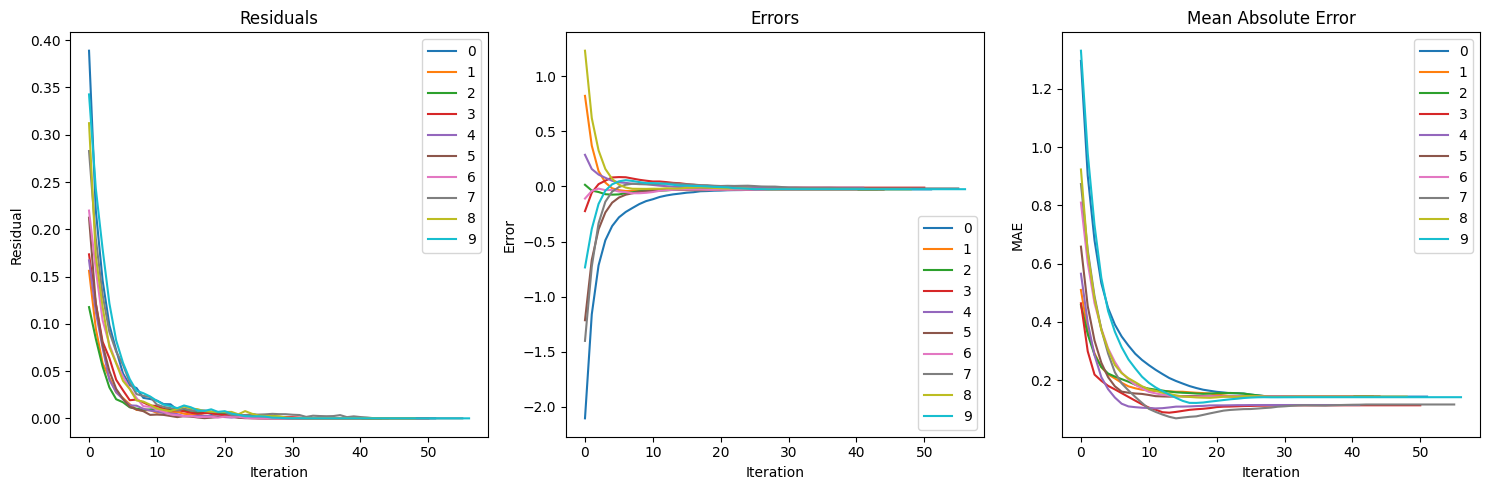

[-0.02304998 -0.09987775  0.04307246  0.03700717 -0.15859342 -0.44495333]


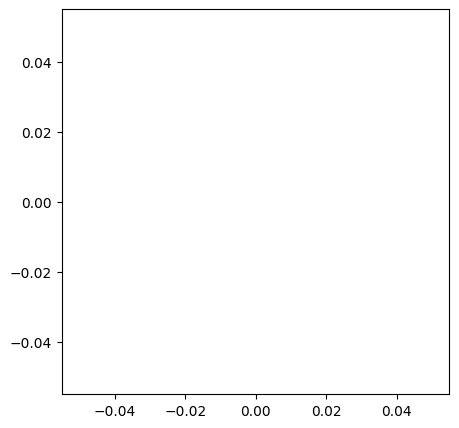

In [73]:
pose_labels = ['x', 'y', 'z', 'a', 'b', 'c']
map_data = map_df[pose_labels].values 

# randomly sample rows of map to get observations 
N = 1000 
idx = np.random.choice(len(map_data), N, replace=False) 
map_sample = map_data[idx] 
true_transform = np.random.normal(0, 5, 6) # T_R_S 
true_transform_invert = invert_pose6D(true_transform) # T_S_R     
observation = apply_delta_pose(true_transform_invert, map_sample) # T_S_t = T_S_R @ T_R_t 
initial_guess_uncertainty = 1.0  
N_guesses = 10  

# set up map 
map = contact_pose_map(map_data)  
map.downsample_map(100_000) 
map.set_observation(observation, true_transform)  
map.add_noise_to_observation(1.0)  
map.set_initial_guesses(true_transform, initial_guess_uncertainty, N_guesses) 

# solve ICP 
map.run_ICP(max_iter=100, tol=1e-18, flag_iteration_output=True, flag_plot_results=True)  
print(map.transform_final_error) 

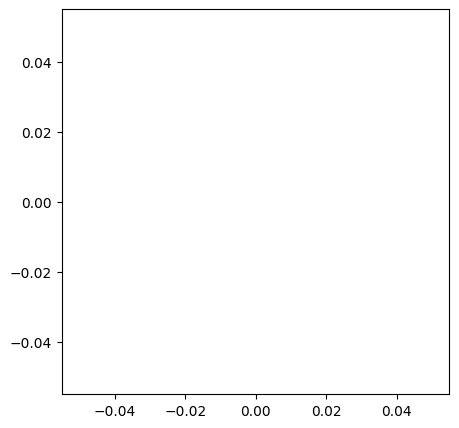

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(5,5)) 
for i in range(len(map.MAE)): 
    ax.scatter(map.MAE[i][0], map.MAE[i][-1]) 

In [76]:
map.MAE[i][-1] 

np.float64(inf)